In [1]:
from code.adjustable_efficient_non_unitary import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
import scipy

In this notebook we present the quantum circuit for the implementation of a block-encoding $\hat{U}_D$ of a non-unitary diagonal operator $\hat{D}$ and we use it to perform a quantum state preparation routine. For instance, let's implement:

$$\hat{U}_D=\begin{pmatrix} \hat{D} & * \\ * & *
    \end{pmatrix},$$
    
with $\hat{D}=\sum_{x}d(x)\ket{x}\bra{x}$ and $d(x)=e^{-\sin(2\pi(x-\frac{1}{2}))^2}$.

In [2]:
# We define the function
def d(x):
    return np.exp(-np.sin(2*np.pi*(x-0.5))**2)

# We define the following arcsin function on which we perform the Walsh approximation
def f(x,d,dmax):
    coef = 1
    return np.arcsin(d(x)/(coef*dmax))

We define the block encoding of $\hat{D}$:

In [3]:
# Number of working qubits
n = 5

# Number of ancilla qubits to parallelize the computation
n_ancilla_diag = 2

# Number of ancilla to copy the control ancilla
n_ancilla_qsp = 2

# Number of operators to implement (maximum value is 2^n)
n_operators = 2**(n-2)

# We generate the non-unitary gate
non_unitary_walsh = non_unitary(n,f,d,n_ancilla_diag,n_ancilla_qsp,n_operators,decomposition='walsh',gray_code=True,swaps=True)

Now, we perform the quantum state preparation by applying $\hat{U}_{D}$ on the state $\ket{s}\otimes \ket{q_A=0}=H^{\otimes n}\ket{0}^{\otimes n}\otimes \ket{q_A=0}=\frac{1}{\sqrt{2^n}}\sum_x \ket{x}\otimes\ket{q_A=0}$, which produces:

$$\ket{\phi}=-i\sqrt{\hat{I}-\left(\frac{\hat{D}}{d_{\max}}\right)^2}\ket{s}\ket{q_A=0}+\frac{\hat{D}}{d_{\max}}\ket{s}\ket{q_A=1}.
$$

In [4]:
q_walsh = QuantumRegister(n,name='q_walsh')
qA_walsh = QuantumRegister(1,name='qA_walsh')
a_walsh = AncillaRegister(n_ancilla_diag,name='a_walsh')
a_qsp_walsh = AncillaRegister(n_ancilla_qsp,name='a_qsp_walsh')

qc_walsh = QuantumCircuit(q_walsh,qA_walsh,a_walsh,a_qsp_walsh)
qc_walsh.h(q_walsh) # We put a Hadamard tower to prepare the state |s>
qc_walsh.append(non_unitary_walsh,qc_walsh.qubits)

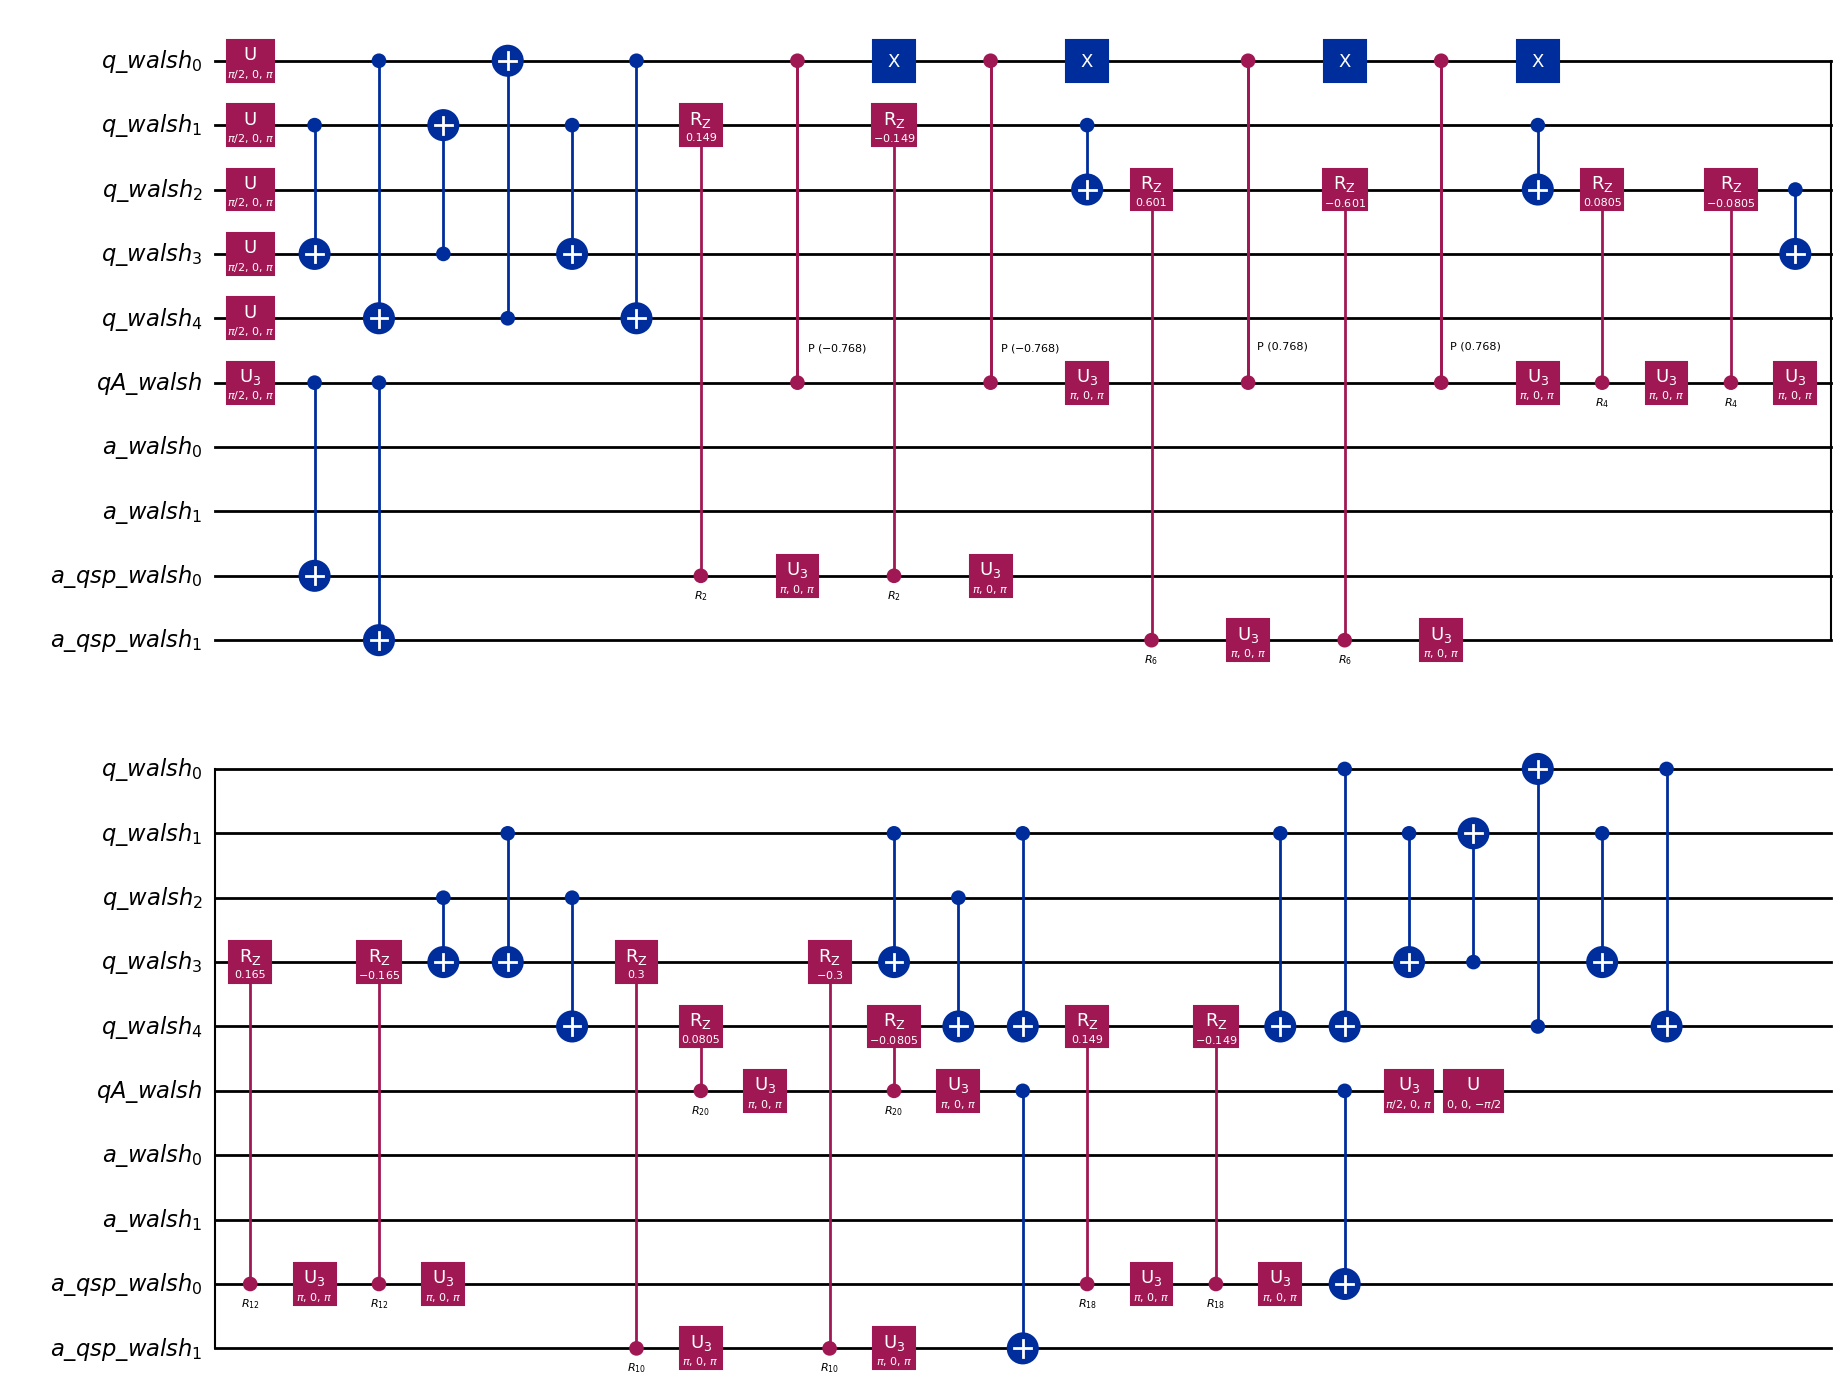

In [5]:
# We plot the circuit
qc_walsh.decompose(reps=3).draw('mpl',style='iqx')

In [6]:
# Circuit depth
print('Depth:', qc_walsh.decompose(reps=3).depth())

# Circuit size
print('Size:', qc_walsh.decompose(reps=3).size())

Depth: 33
Size: 72


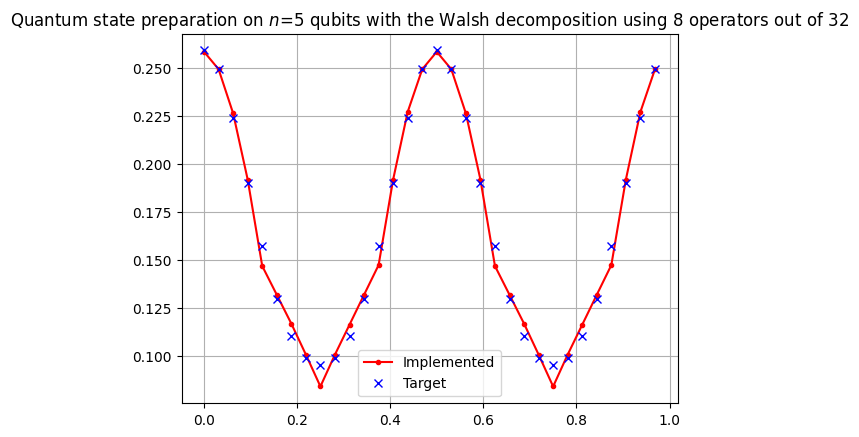

In [7]:
# Verification of the results
state = qi.Statevector.from_instruction(qc_walsh)
state_dict = state.to_dict()
data = []
n_bits = len(list(state_dict.keys())[0])
for i in list(state_dict.keys()):
    if i[n_bits-n-1] == '1':
        data.append(state_dict[i])
L = np.array(data)
X = np.array(range(2**n))/(2**n)
plt.plot(X,np.real(L)/np.linalg.norm(L),marker='.',c='r',label='Implemented')
plt.plot(X,d(X)/np.linalg.norm(d(X)),marker='x',c='b',linestyle='',label='Target')
plt.legend()
plt.title('Quantum state preparation on $n$='+str(n)+' qubits with the Walsh decomposition using '+str(n_operators)+' operators out of '+str(2**n))
plt.grid()
plt.show()

The quantum state preparation routine is achieved with a probability of success given by:
$$
\mathbb{P}(1)=\| \frac{\hat{D}}{d_{\max}}\ket{s}\|^2=\frac{1}{2^n}\sum_{x=0}^{2^n-1}d_x^2/d_{\max}^2 \simeq \frac{\|d\|_{2,[0,1]}^2}{\|d\|_{\infty}^2}.$$

In [8]:
# Proba of success theoretical 
def p(f):
    def h(x):
        return(f(x)**2)
    max_f = scipy.optimize.minimize_scalar(lambda x: -f(x), bounds=[0,1], method='bounded')['fun']
    int = scipy.integrate.quad(h, 0, 1, args=(), epsabs=1.49e-08, epsrel=1.49e-08, limit=50)
    return(int[0]/max_f**2)

print('Success probability:', np.linalg.norm(L)**2)
print('Theoretical success probability:', p(d))

Success probability: 0.46742102508601474
Theoretical success probability: 0.4657596075936404
